# Visualizing the stock market structure

https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

This example employs several unsupervised learning techniques to extract the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes that are linked tend to cofluctuate during a day.

## Get data

The data is from 2003 - 2008. This is reasonably calm: (not too long ago so that we get high-tech firms, and before the 2008 crash). This kind of historical data can be obtained for from APIs like the quandl.com and alphavantage.co ones.


In [4]:
# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold

print(__doc__)


# #############################################################################
# Retrieve the data from Internet

# The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# that we get high-tech firms, and before the 2008 crash). This kind of
# historical data can be obtained for from APIs like the quandl.com and
# alphavantage.co ones.

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

print('Started fetching data ...')
for symbol in symbols:
#     print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    quotes.append(pd.read_csv(url.format(symbol)))
print('Done fetching data.')

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


Automatically created module for IPython interactive environment
Started fetching data ...
Done fetching data.


In [5]:
print('variation.shape = ', variation.shape)
variation

variation.shape =  (56, 1258)


array([[ 0.44,  0.1 , -0.13, ..., -0.38, -0.76, -1.42],
       [ 2.2 ,  0.07,  2.02, ..., -1.08, -0.32,  0.93],
       [ 0.38,  0.93,  0.3 , ...,  1.58, -0.82, -1.17],
       ...,
       [ 0.47,  0.25,  0.93, ..., -1.27,  0.74, -0.7 ],
       [ 0.07,  0.12,  0.21, ..., -0.14,  0.13, -0.13],
       [ 1.01,  0.6 ,  1.09, ...,  0.11, -0.21,  0.04]])

## Learning a graph structure

We use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others. Specifically, sparse inverse covariance gives us a graph, that is a list of connection. For each symbol, the symbols that it is connected too are those useful to explain its fluctuations.

In [6]:
# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV()

In [15]:
print('X.shape = ',  X.shape)
X

X.shape =  (1258, 56)


array([[ 0.28767224,  2.8941053 ,  0.39299438, ...,  0.65372633,
         0.30758692,  1.5782723 ],
       [ 0.06538006,  0.09208517,  0.96180204, ...,  0.34772677,
         0.52729187,  0.93758751],
       [-0.08499407,  2.65731487,  0.31025872, ...,  1.2935436 ,
         0.92276077,  1.70328397],
       ...,
       [-0.24844421, -1.4207426 ,  1.63402927, ..., -1.76645201,
        -0.61517385,  0.17189104],
       [-0.49688842, -0.42096077, -0.84804051, ...,  1.02927125,
         0.57123286, -0.32815563],
       [-0.92839678,  1.22341724, -1.21000902, ..., -0.97363497,
        -0.57123286,  0.06250583]])

In [9]:
edge_model

GraphicalLassoCV()

In [11]:
print('edge_model.covariance_.shape = ', edge_model.covariance_.shape)
edge_model.covariance_

edge_model.covariance_.shape =  (56, 56)


array([[1.        , 0.11688057, 0.18663037, ..., 0.14515001, 0.07350655,
        0.11110756],
       [0.11688057, 1.        , 0.12831835, ..., 0.16457825, 0.12809932,
        0.13602012],
       [0.18663037, 0.12831835, 1.        , ..., 0.10767648, 0.10497764,
        0.32003579],
       ...,
       [0.14515001, 0.16457825, 0.10767648, ..., 1.        , 0.09835048,
        0.10572877],
       [0.07350655, 0.12809932, 0.10497764, ..., 0.09835048, 1.        ,
        0.12319637],
       [0.11110756, 0.13602012, 0.32003579, ..., 0.10572877, 0.12319637,
        1.        ]])

## Clustering

We use clustering to group together quotes that behave similarly. Here, amongst the various clustering techniques available in the scikit-learn, we use Affinity Propagation as it does not enforce equal-size clusters, and it can choose automatically the number of clusters from the data.

Note that this gives us a different indication than the graph, as the graph reflects conditional relations between variables, while the clustering reflects marginal

In [12]:
# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_,
                                         random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: McDonald's
Cluster 8: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 9: Kellogg, Coca Cola, Pepsi
Cluster 10: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 11: Canon, Honda, Navistar, Sony, Toyota, Xerox


# Embedding in 2D space

For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this we use Manifold learning techniques to retrieve 2D embedding.

In [13]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

In [16]:
print('embedding.shape = ',  embedding.shape)
embedding

embedding.shape =  (2, 56)


array([[-0.03133457, -0.10085752, -0.03196732, -0.08565947,  0.00867911,
        -0.10968898,  0.023698  , -0.03050856, -0.09036982, -0.0979985 ,
         0.40342683, -0.06535529, -0.09821818, -0.0781259 ,  0.37519749,
        -0.06055747, -0.06049054, -0.05551777, -0.02190345, -0.10630194,
        -0.05105478,  0.12884665, -0.07331181,  0.09111769, -0.06057465,
        -0.07096079, -0.09648828, -0.08914968, -0.09164275, -0.04852844,
        -0.06430036, -0.06559589, -0.07657756, -0.09177229, -0.02456882,
         0.01952134,  0.16918205, -0.0856531 , -0.00188195, -0.09252651,
        -0.03204468, -0.00692426, -0.02722191,  0.01286955,  0.15994247,
         0.04671119,  0.33992381, -0.09725258, -0.03543681,  0.16549804,
         0.35953018, -0.10711761, -0.09375813,  0.36123698, -0.01145603,
        -0.04472645],
       [-0.13399636,  0.16073548, -0.19185169,  0.12341667, -0.1408095 ,
         0.19147679, -0.26434442, -0.0714396 ,  0.1486001 ,  0.05684736,
         0.17536752, -0.13420

## Visualization

The output of the 3 models are combined in a 2D graph where nodes represents the stocks and edges the:

cluster labels are used to define the color of the nodes

the sparse covariance model is used to display the strength of the edges

the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as visualization is crucial here to display the graph. One of the challenge is to position the labels minimizing overlap. For this we use an heuristic based on the direction of the nearest neighbor along each axis.

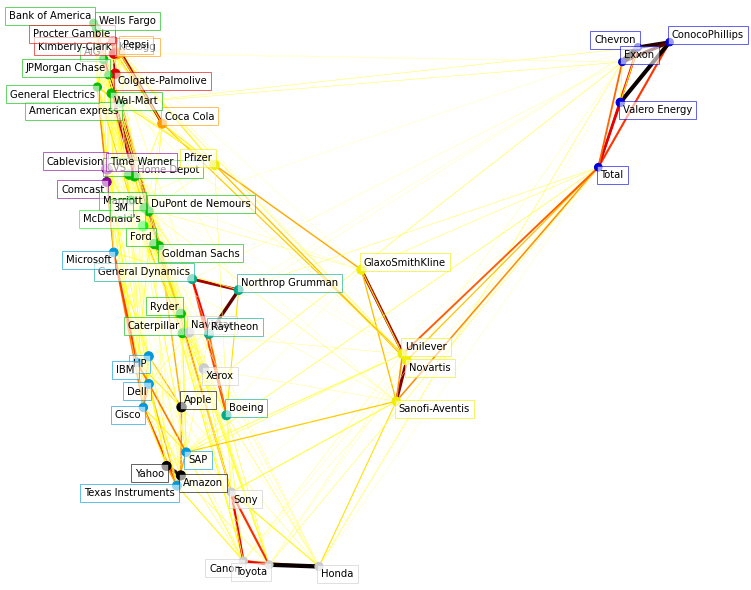

In [17]:
# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()